In [1]:
from datasets import load_dataset
from transformers import pipeline

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

In [2]:
device = 'gpu'
model_ckpt = 'facebook/bart-large-cnn'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

In [3]:
import torch

if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

GPU is not available


In [4]:
#https://huggingface.co/datasets/ccdv/govreport-summarization/
gov = load_dataset('govreport-summarization')
gov

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\datasets\load.py:926: FutureWarning: The repository for govreport-summarization contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at govreport-summarization\govreport-summarization.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['report', 'summary'],
        num_rows: 17517
    })
    validation: Dataset({
        features: ['report', 'summary'],
        num_rows: 973
    })
    test: Dataset({
        features: ['report', 'summary'],
        num_rows: 973
    })
})

In [5]:
gov['train'][0]

{'report': 'The structure of the armed forces is based on the Total Force concept, which recognizes that all elements of the structure—active duty military personnel, reservists, defense contractors, host nation military and civilian personnel, and DOD federal civilian employees—contribute to national defense. In recent years, federal civilian personnel have deployed along with military personnel to participate in Operations Joint Endeavor, conducted in the countries of Bosnia-Herzegovina, Croatia, and Hungary; Joint Guardian, in Kosovo; and Desert Storm, in Southwest Asia. Further, since the beginning of the Global War on Terrorism, the role of DOD’s federal civilian personnel has expanded to include participation in combat support functions in Operations Enduring Freedom and Iraqi Freedom. DOD relies on the federal civilian personnel it deploys to support a range of essential missions, including intelligence collection, criminal investigations, and weapon systems acquisition and main

In [6]:
report_len = [len(x['report'].split()) for x in gov['train']]
summary_len = [len(x['summary'].split()) for x in gov['train']]

array([[<AxesSubplot:title={'center':'Report Length'}>,
        <AxesSubplot:title={'center':'Summary Length'}>]], dtype=object)

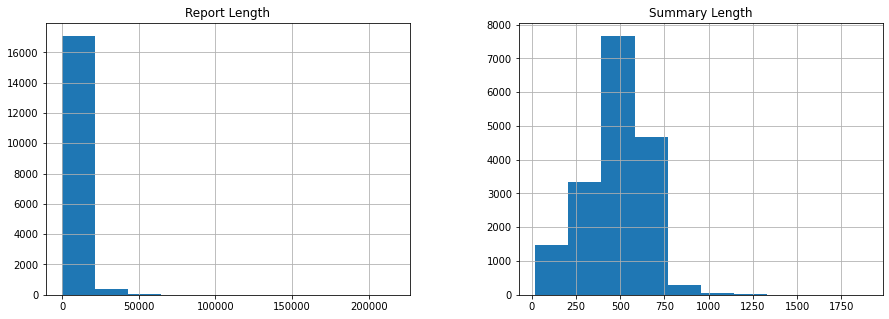

In [7]:
import pandas as pd

data = pd.DataFrame([report_len, summary_len]).T
data.columns = ['Report Length', 'Summary Length']

data.hist(figsize=(15,5))

In [8]:
# lets build Data Collator

def get_feature(batch):
  encodings = tokenizer(batch['report'], text_target=batch['summary'],
                        max_length=1024, truncation=True)

  encodings = {'input_ids': encodings['input_ids'],
               'attention_mask': encodings['attention_mask'],
               'labels': encodings['labels']}

  return encodings

In [9]:
gov_pt = gov.map(get_feature, batched=True)

Map:   0%|          | 0/973 [00:00<?, ? examples/s]

In [10]:
gov_pt

DatasetDict({
    train: Dataset({
        features: ['report', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 17517
    })
    validation: Dataset({
        features: ['report', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 973
    })
    test: Dataset({
        features: ['report', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 973
    })
})

In [11]:
columns = ['input_ids', 'labels', 'attention_mask']
gov_pt.set_format(type='torch', columns=columns)

In [12]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [13]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = 'bart_gov',
    num_train_epochs=1,
    warmup_steps = 500,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay = 0.01,
    logging_steps = 10,
    evaluation_strategy = 'steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16
)

trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, data_collator=data_collator,
                  train_dataset = gov_pt['test'], eval_dataset = gov_pt['validation'])

In [14]:
trainer.train()

In [15]:
trainer.save_model('bart_gov_model')

In [19]:

pipe = pipeline('summarization', model='bart_gov_model')
gen_kwargs = {'length_penalty': 0.8, 'num_beams': 8, "max_length": 128}


custom_dialogue="""An unregulated child custody transfer, commonly referred to as rehoming, is not an adoption. It is a practice in which parents seek new homes for their children and place them without the safeguards and oversight of the courts or the child welfare system. This practice does not pertain exclusively to adopted children; biological children may also be subject to unregulated transfers. However, media reports and child welfare and adoption organizations have focused on unregulated transfers of adopted children that involve families who may be unable or unwilling to deal with the emotional and behavioral challenges that may be caused by a childâ€™s pre-adoption conditions. For example, some adopted children may have histories of long-term institutionalization (e.g., orphanages), abuse, or other traumatic experiences that affect their behavior. An adoption may be terminated as a result of a disruption, which occurs before the adoption is finalized, or a dissolution, which occurs after the adoption has been finalized, generally in a legal proceeding. Under these circumstances, the child would go into the child welfare system or be legally adopted by another family. In contrast, unregulated transfers occur when parents intend to permanently transfer custody of their child to a new family without following these steps. Sometimes the parents will use a document called a power of attorney to delegate to the new family certain authority for the care and control of the child, although such documents do not terminate the legal relationship between the adoptive parents and the child. Because power of attorney arrangements are generally not overseen by any state or federal agency, information on the whereabouts of a child subject to an unregulated transfer using a power of attorney can be limited or unknown. In addition, because families who engage in an unregulated transfer do not follow the steps required for a legally recognized adoption, there may be no checks to ensure that the new home is an appropriate place for the child. There are different ways that a child can be adopted in the United States. International adoptions involve a child who was born in another country. Domestic adoptions can be adoptions from foster care, which involve children in the child welfare system whose biological parents have had their parental rights terminated. Other domestic adoptions include those conducted through private adoption agencies, attorneys, and others. Most domestic adoptions handled through private adoption agencies, attorneys, and others primarily involve infants or adoptions by a stepparent. Unregulated transfers do not follow the adoption process, which generally involves many steps to help ensure that the child is legally adopted and placed in an appropriate and permanent home. While the adoption process can be different depending on the state and type of adoption, it typically consists of: a home study performed by a licensed professional to assess the suitability of the prospective parents, such as their health, finances, and criminal history; an immigration application and petition, in the case of an international pre-adoption training for prospective parents, either online or in- person, for a specified number of hours on topics such as the adoption process and issues related to attachment and bonding; final approval of the adoption by a court, either in the United States or the childâ€™s country of origin; and post-placement or post-adoption services, in some cases, which can range from information and referral services and peer support groups to more intensive services for children with severe behavioral needs. For example, these intensive services can include mental health counseling, respite care programs to provide temporary relief for caregivers by placing children in short-term accommodations outside the home, and residential treatment, which involves extended treatment services to children while they reside outside the home. Multiple federal, state, and other agencies can be involved in different stages of the adoption process, depending on the type of adoption. Fees also vary by type of adoption; while foster care adoptions may not have any fees, international adoptions can involve substantial financial investments from families. International adoptions. As required under federal law and State Department regulations, international adoptions are generally conducted through accredited adoption agencies or approved persons. USCIS is involved in adjudicating immigration petitions for these children as well as setting federal home study requirements for international adoptions and determining the suitability and eligibility of prospective adoptive parents. The State Department also sets requirements for pre-adoption training that international adoption agencies and approved persons must provide for prospective parents. There are no federal requirements for post- adoption monitoring for international adoptions, according to State Department officials. However, officials said some countries of origin require adoptive families to provide periodic reports (e.g., according to the State Departmentâ€™s website, one country requires families to provide reports every 6 months for 2 years following an international adoption). Individual states may also have separate licensing requirements for international adoption agencies operating in their state. Foster care adoptions. Foster care adoptions are typically conducted by state, county, and local child welfare agencies or private adoption agencies with which they contract. For these adoptions, states set requirements for home studies, pre-adoption training, and post-adoption services. Private domestic adoptions. States also set requirements for home studies, pre-adoption training, and post-adoption services for private domestic adoptions, generally through state licensing standards and other requirements for private adoption agencies, attorneys, and others. Some federal funding is available for adoption services, in addition to any funding from state, local, or other sources. Funding appropriated for Title IV-E of the Social Security Act makes up the large majority of federal funding dedicated to child welfare, comprising about 89 percent of federal child welfare appropriations (approximately $7.4 billion of nearly $8.3 billion) in fiscal year 2015, according to the Congressional Research Service. While the majority of these Title IV-E funds support children in the foster care system, the Title IV-E Adoption Assistance program provides grants to states for a portion of their costs to support families who adopted children with special needs, generally from foster care. For example, states provide ongoing monthly Adoption Assistance payments (subsidies) to eligible families that can be used to help pay for the costs of care for the child, which might include therapy and other post-adoption services. Funds appropriated for this program totaled about $2.5 billion in fiscal year 2015, comprising about 34 percent of Title IV-E program funding. In addition, Title IV-B of the Social Security Act, which is the primary source of federal child welfare funding available for child welfare services, also provides funds that states can use to support adoptions by any family. For example, states may use funds to support pre- and post- adoption services, although funds can also be used for a variety of other purposes to keep children safe and in stable families. Federal appropriations for Title IV-B comprised about 8 percent of dedicated federal child welfare appropriations (approximately $664 million of nearly $8.3 billion) in fiscal year 2015. Table 1 provides a summary of federal child welfare funding that states can use for adoption services, including programs under Title IV-E and IV-B of the Social Security Act. In addition to these programs, states may use savings generated from changes made to the eligibility criteria for the Title IV-E Adoption Assistance program for adoption services. These changes made additional children eligible for federal Title IV-E Adoption Assistance payments, thereby potentially freeing up state funds previously used for this purpose. The Preventing Sex Trafficking and Strengthening Families Act requires states to use 30 percent of these savings for post- adoption and related services. In addition, states may use different combinations of federal funds not specifically dedicated to child welfare to support adoption services, such as funds available under the Temporary Assistance to Needy Families block grants, Medicaid, and Social Services Block Grants. While states can use federal funds to support adoption services for families, we reported in January 2013 that federal funding for services designed to prevent children from entering foster careâ€”such as adoption support servicesâ€”can be limited. HHS does not collect information on how much states spend in federal funds specifically for post-adoption services. In addition, our prior work has shown that some states may not have information on the extent to which they use these federal funds for adoption services. Although states are to use savings generated from changes to the Title IV-E Adoption Assistance program for child welfare services, we reported in May 2014 that only 21 states reported calculating these savings for fiscal year 2012, and 20 states reported difficulties performing the calculations. In 2014, the Donaldson Adoption Institute attempted to collect information on statesâ€™ annual post-adoption service budgets, excluding Title IV-E Adoption Assistance program subsidies. However, it reported that some states were unable to distinguish this budget item, especially when the primary programs that served adoptive families also served other families. It also reported that states with county-administered child welfare programs were unable to report total state budgets for post-adoption services. The Institute reported that annual budgets for these services ranged from $85,000 to $11.2 million in the 21 states that provided responses to the survey it conducted. International adoptions in the United States have changed over time from a system that predominantly involved the adoption of infants and toddlers to one that has involved an increasing proportion of older children and those with special needs. According to State Department data, less than 8 percent of children adopted internationally in fiscal year 2013 were younger than 1 year compared to over 40 percent in fiscal year 2004. In addition, one study reported in 2013 that nearly half of more than 1,000 parents surveyed who adopted internationally said their children had diagnosed special needs. The State Department, HHS, and others have reported that the changing landscape of international adoptions is attributable to many different factors, including positive cultural factors and socio-economic conditions in other countries that have made it easier for biological families to take care of their children or to adopt domesticallyâ€”decisions that have impacted the number of children eligible for adoption by U.S. families. About 7,000 children were adopted internationally in fiscal year 2013 compared to nearly 23,000 in fiscal year 2004 (see fig. 1). Children in foster care may also be more likely to have special needs than children in the general population. According to a national survey conducted in 2008 and 2009, more than 42 percent of children ages 18 months to 17 years who were placed in a foster family home following an investigation of abuse and neglect were found to be at risk for an emotional or behavioral problem and potentially in need of mental health services. Multiple studies have shown that abuse and other maltreatment can cause changes in the brain development of children, and these changes may leave them more vulnerable to depression, post-traumatic stress disorder, and other behavioral or mental health issues. Studies show that children who are institutionalizedâ€”for example, in orphanages prior to being adopted by a familyâ€”are often subject to deprivation and neglect. Young children with a history of institutional care often show poor attention, hyperactivity, difficulty with emotion regulation, elevated levels of anxiety, and increased rates of attachment disorders. For example, they may develop Reactive Attachment Disorder, which is characterized by serious problems in emotional attachments to others. The physical, emotional, and social problems associated with this disorder may persist as the child grows older. Families who adopt children with severe behavioral or mental health issues may face situations which can put the family in crisis. For example, the adopted child may be violent toward siblings or parents. One study reported in 2014 that in 23 percent of cases where adoptions were dissolved, the adopted child was a threat to the safety of other children in the home. Families may choose an unregulated child custody transfer because they were not sufficiently prepared for the challenges they experienced in their adoption, according to many child welfare and adoption stakeholders we interviewed. This lack of preparation may include inadequate information about the childâ€™s health, an insufficient home study to make a good match, and minimal pre-adoption training for parents. Many stakeholders we interviewedâ€”including officials from selected states, child welfare and adoption organizations, and adoption agenciesâ€” expressed concern with the adequacy of the information provided to prospective parents on the behavioral and mental health conditions of a child adopted internationally. Access to accurate information is critical to ensuring that a family is aware of the type of ongoing support they may need for the child. However, officials from 11 of 19 child welfare and adoption organizations and 5 of 15 adoption agencies said families who adopt internationally often do not receive complete information on a childâ€™s medical and behavioral needs before adopting. State Department officials explained that some low-income countries lack sufficient mental health care providers, making it difficult for international adoption agencies to ensure that children are accurately evaluated prior to adoption. USCIS officials also said some countries do not allow prospective adoptive parents to review medical history documents until after an adoption is finalized for privacy reasons. Many stakeholders also expressed concern that families may not have undergone an adequate home study to ensure they are a good match for their adopted child, and several noted that the home study is a critical point in the pre-adoption process, when social workers or adoption agency staff try to determine how families will handle challenges when parenting their adopted child. According to HHS officials, requirements for what should be assessed during a home study are determined by individual states for foster care adoptions. Home study requirements are determined by USCIS and the State Department for international adoptions. However, officials from 4 of 7 selected states and 8 of the 15 adoption agencies we interviewed expressed concerns about inconsistencies in the quality of home studies conducted by child welfare and adoption agencies across states. For example, Ohio officials said all child welfare and adoption agencies in their state are required to use a detailed home study format. They said they may not accept home studies conducted in other states that have less stringent requirements unless additional supporting documentation is provided, such as a background check and safety check of the home. Families also may not have received sufficient or targeted pre-adoption training to ensure they were prepared for their childâ€™s specific needs, particularly for international adoptions, according to most stakeholders we interviewed. For foster care adoptions, states each set their own training requirements for prospective parents, according to HHS officials. About half of all states require agencies facilitating these adoptions to provide prospective parents with at least 27 hours of training, according to data obtained from HHS officials in May 2015. Our seven selected states have requirements of 18 to 47 hours of training for foster care adoptions with some in-person required training in each state, according to state officials. Many of our selected states also use similar training models for foster care adoptions, including Parent Resources for Information, Development, and Education (PRIDE) and Model Approach to Partnerships in Parenting (MAPP), which were developed by various child welfare organizations. In contrast, State Department regulations require 10 hours of training for international adoptions, all of which can be online. This training must cover topics defined by the federal regulations. Officials we interviewed from 5 of our selected states, 12 child welfare and adoption organizations, and 11 adoption agencies told us that this training may be insufficient, particularly since an increasing proportion of children adopted internationally are older and have special needs due to an extensive history of institutionalization and trauma. State Department officials told us they are considering revisions to pre-adoption training requirements for international adoptions, which we discuss later in the report. States may set training requirements for international adoptions above the 10-hour minimum or may have required training topics. Two of our seven selected states require more than 10 hours of training, according to state officials. For example, Wisconsin officials told us the state requires 18 hours of training, and the same topics are required for international and foster care adoptions. This training covers issues such as attachment in adoptive placement, the effects of abuse and neglect, and cultural sensitivity. In addition, this training includes opportunities to cover issues specific to the individual child (see table 2). State Department officials said international adoption agencies may also have their own training requirements beyond those of federal and state agencies. For example, officials from one international adoption agency said they require 30 hours of training for parents wishing to adopt abroad. This includes training on grief and loss, the childâ€™s country of origin and cultural differences, the impact of institutionalization, and potential challenges and service needs. These officials said this expanded training is more costly for both the agency and prospective parents, and that some prospective parents thought the training was too cumbersome or expensive. Officials in most of the selected states, child welfare and adoption organizations, and adoption agencies we interviewed expressed concern that families may choose an unregulated transfer when they cannot access post-adoption services to help them cope with or avoid reaching a crisis point in their adoption. Several of these stakeholders explained that an adopted child may deal with continuing issues of attachment, identity, and loss of previous caregivers or biological parents. While services to help adoptive families can include information, referrals, and peer support groups, families who adopted children with severe behavioral needs may need more intensive services, such as mental health counseling, respite care, and residential treatment. Many stakeholders we interviewed suggested that families considering unregulated transfers may particularly need these intensive services. All seven of our selected states provide some kind of post-adoption services for families who adopted from foster care and internationally. For example, Wisconsin officials said the state provides parent training, a 24-hour information hotline, referral services, and mechanisms to link families to support groups and mentors, which are available to all adoptive families. Other types of services these selected states provide include lending libraries, newsletters, and brochures for parents. However, the seven selected states offered limited intensive services, particularly for international adoptions, according to our analysis of the information gathered from selected state officials. Officials from three states said their state offers counseling and other intensive services, such as case management and crisis intervention, to both families who adopted from foster care and internationally. However, officials from the six states that offer respite care and the four states that provide residential treatment told us their states provide these services exclusively to families who adopted from foster care. Some of these services have maximum time limits or are offered on a case-by-case basis. For example, Louisiana officials said their state offers respite care for up to 1 month, and Florida and Illinois officials said their states offer residential treatment services to families who adopted from foster care on a case-by-case basis. In addition, our seven selected states provide varying levels of financial support to eligible adoptive families through subsidies and cash assistance programs, according to the information gathered from selected state officials. For example, Ohio officials described a state program that uses Title IV-B and state revenue funds to provide up to $10,000 per child per year to pay service providers in 2014, with an additional $5,000 available per year if the child is recommended for residential treatment by a mental health provider. In addition, all of our selected states received federal funds under the Title IV-E Adoption Assistance program to provide subsidies to eligible adoptive families; the maximum subsidy amounts ranged from $400 to $2,700 per month in 2014. However, they are generally only available to eligible families who adopted children with special needs from foster care, and information is limited on how much families use their subsidies for services, such as counseling, versus other expenses for their adopted child, such as food, clothing, and day care. The Donaldson Adoption Institute reported in April 2014 on a variety of post-adoption services provided by 49 states that responded to survey questions about such services. It found that about one-third of these states offered almost no post-adoption services other than a subsidy for adoptive families. In addition, the report found that the majority of these states had services that were open exclusively to families who adopted from foster care. Officials in four of our seven selected states told us that the need for post- adoption services exceeded the funding available from state and federal programs. Our prior work has shown that child welfare agencies have struggled to meet the service needs of families. Our 2013 report found that local child welfare officials in four states we reviewed reported service gaps in multiple areas, including counseling and mental health services. We also reported that state and local child welfare agencies may face difficult decisions when determining which activitiesâ€”aimed at preserving families and preventing a child from entering foster careâ€”to prioritize and fund, particularly in light of the ongoing fiscal challenges these agencies face. Similar to our selected states, officials from 12 of the 15 adoption agencies we interviewed said they provide some level of post-adoption services to families, such as information and referrals. Officials in 4 of the 15 adoption agencies said they provide intensive services, ranging from trauma-focused therapy to a weekend respite care program. Officials from six adoption agencies noted that resource constraints have affected their ability to provide post-adoption services. Officials from the Council on Accreditationâ€”the organization responsible for accrediting agencies for international adoptionsâ€”said some international adoption agencies have struggled to maintain their businesses due to the decrease in the number of international adoptions overall (a decrease of 70 percent between fiscal years 2003 and 2014). They said while some larger agencies have been better able to provide services because they are financially stable, this can be a challenge for other agencies. Another limitation to accessing post-adoption services that many stakeholders expressed concern about was the cost of intensive services, which can be expensive for all families. Officials in 3 of 7 selected states, 6 of 19 child welfare and adoption organizations, and 5 of the 15 adoption agencies we interviewed said services can be expensive, particularly intensive services such as mental health counseling and residential treatment. We have previously reported that the cost to support a youth in a residential setting can amount to thousands of dollars per month. In addition to cost, adoptive families may have challenges finding mental health providers that are â€œadoption competentâ€â€”that is, knowledgeable about adoption-related issues, according to officials from five selected states, seven child welfare and adoption organizations, and eight adoption agencies. These stakeholders said mental health providers who do not understand issues unique to adoptive families will likely be less effective in helping these families work through issues. For example, one official told us adoptive families need therapists who can distinguish between normal adolescent behavior and a child acting out due to grief and loss resulting from his or her adoption. Several stakeholders also noted that families in rural areas may have even more difficulty accessing effective mental health providers. We reported in 2013 that a Florida behavioral health service provider had been advertising a child psychiatrist position for 5 years without success. In a 2011 report, we found that child psychiatrists and psychologists were among the most difficult specialist referrals to obtain for children in low-income families covered by Medicaid and the Childrenâ€™s Health Insurance Program, both of which can cover children adopted from foster care and internationally. Lastly, families may not know about available services from their child welfare or adoption agency, and therefore do not seek help when needed, according to officials from four selected states and five adoption agencies. For example, Virginia officials said families that did not adopt from foster care may not know about support services they can access through their local child welfare agency. Wisconsin officials also said they struggle to find sufficient resources to provide outreach to all adoptive parents about state resources. Officials from two selected states also raised concerns that families may not remember whether their adoption agency provides post-adoption services. They explained that some families may not need services for years after an adoption is final because issues may not arise until the child reaches adolescence. By that point, families may no longer have contact with their adoption agency. Families in need of help may be reluctant to ask child welfare agencies for assistance, according to officials from three child welfare and adoption organizations and four adoption agencies. For example, these officials noted that there is a stigma associated with contacting child welfare agencies since those agencies are also generally responsible for investigating cases of child abuse. A few of these officials further noted that families, including those who adopted from foster care and internationally, may fear that contacting an agency will prompt an investigation into how they care for all of their children. They also said families may be afraid that they will not be able to adopt again if they are involved with a child welfare agency. Officials in five of our seven selected states acknowledged the dilemma that families face if they contact child welfare agencies for services. In addition, officials in one selected state said parents cannot voluntarily relinquish custody of a child in their state (e.g., for care or services) without being charged with child abandonment. Officials in all seven selected states said families who decide to relinquish custody to the state may be required to pay ongoing child support. Similarly, families who adopted internationally may also be hesitant to reach out to their adoption agency. Representatives from 9 of the 15 adoption agencies we interviewed told us that families may be ashamed or embarrassed to contact the agency to discuss problems. Representatives from one adoption agency explained that families have gone through a rigorous home study process to prove that they will provide a good home to an adopted child. Thus, they said these families may be reluctant to contact their agency and admit that that they are facing challenges in their adoptions. Because unregulated child custody transfers are an underground practice that happens outside the purview of the courts and the child welfare system, they are difficult to track, and no federal agency keeps statistics on their occurrence. These transfers may involve an exchange of a power of attorney that may not be filed with or approved by a court of law, although it may be signed by both parties and notarized. State laws vary, but generally a parent may use a power of attorney to temporarily grant another person certain powers regarding their childâ€™s care and physical custody, such as the authority to make medical and educational decisions. For example, a military service member may sign a power of attorney to allow a family member or friend to take care of and make medical decisions for his or her child while he or she is deployed. However, because a power of attorney does not terminate the legal parent-child relationship, the adoptive parent still retains certain rights and responsibilities. For example, according to HHS, delegating responsibility for a child through a power of attorney does not insulate adoptive parents from state laws regarding imminent risk of serious harm. State laws determine any time limits (e.g., 1 year) for grants of power of attorney, and also establish the procedures required to make such an arrangement effective. For example, officials in three of our seven selected states told us their state laws do not require power of attorney documents to be approved by a court, and officials in one selected state said their laws require court approval in certain circumstances. However, officials in three of these selected states said they were not aware of any mechanisms in their states to track expired power of attorney documents to determine if families are attempting to use them to permanently transfer custody. Unregulated transfers are also difficult to track because many adoptions are not monitored after the adoption is finalized. For those international adoptions subject to reporting requirements set by individual countries, reporting may occur for a limited time. For example, according to the State Department website, one country requires adoptive parents to provide information about the adoption at certain time intervals for the first 2 years. Officials from the State Department and several adoption agencies we interviewed told us that while parents may sign a contract when they adopt a child saying they will report the required information to the adoption agency, parents may not comply with post-adoption reporting requirements, and agencies have little leverage to enforce compliance. In addition, officials in our seven selected states said their state does not specifically monitor whether adopted children remain with their families after the adoption is finalized. Our observations of forums on social media websites indicate that some parents have been using these venues to seek new homes for their children. We observed posts in five social media forums and found a total of 23 posts in which a person wrote that they were seeking a new family for their child. Among the 9 posts that included information on a childâ€™s age, those ages ranged from 7 to 16. Generally, parents in these forums who said they wanted to transfer a child indicated that they were in distress or crisis, and most often said they were seeking a new home because of the childâ€™s behavioral issues or severe mental illness. These children included those who were adopted from foster care and internationally. For example, one post asked for a new home for a 7-year- old boy who had been diagnosed with numerous mental illnesses, including Reactive Attachment Disorder"""

summ = pipe(custom_dialogue, **gen_kwargs)
print(summ)


Unregulated child custody transfer, also known as rehoming, is a practice where parents seek new homes for their children without the safeguards and oversight of the courts or the child welfare system. This practice does not apply exclusively to adopted children, but it can also occur to biological children. Media reports and child welfare and adoption organizations have focused on unregulated transfers of adopted children that involve families who may be unable or unwilling to deal with the emotional and behavioral challenges caused by a child's pre-adoption conditions. Unregulated transfers do not follow the adoption process, which generally involves many steps to ensure that the child is legally adopted and placed in an appropriate and permanent home. The adoption process can vary depending on the state and type of adoption, but typically consists of a home study performed by a licensed professional to assess the suitability of the prospective parents, an immigration application and

In [23]:
"""
from evaluate import load
# Load the ROUGE metric
import evaluate
rouge = evaluate.load('rouge')
test_data = gov_pt['test']

candidates = load_dataset("ccdv/govreport-summarization", split="test[:100]")

references = [[normalizeString(l['report']), normalizeString(l['summary'])] for l in test_data]

results = rouge.compute(predictions=candidates, references=references)
print(results)
"""
print("{'rouge1': 0.5600584688470674, 'rouge2': 0.4251288612685067, 'rougeL': 0.5447115841403253, 'rougeLsum': 0.5542115841403253}")

{'rouge1': 0.5600584688470674, 'rouge2': 0.4251288612685067, 'rougeL': 0.5447115841403253, 'rougeLsum': 0.5542115841403253}
